In [1]:
#Taken from - https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch18.html#mdp_diagram

In [2]:
import numpy as np

In [3]:
transition_probabilities = [[[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
                           [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
                           [None, [0.8, 0.1, 0.1], None]]
rewards = [[[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
           [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
           [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0,1,2], [0,2], [1]]

In [4]:
Q_values = np.full((3,3), -np.inf)
for state, action in enumerate(possible_actions):
    Q_values[state, action] = 0.0

In [5]:
gamma = 0.9

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s,a] = np.sum(transition_probabilities[s][a][sp]*(rewards[s][a][sp]+gamma*np.max(Q_prev[sp])) for sp in range(3))

<ipython-input-5-6850da6ee482>:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  Q_values[s,a] = np.sum(transition_probabilities[s][a][sp]*(rewards[s][a][sp]+gamma*np.max(Q_prev[sp])) for sp in range(3))


In [6]:
Q_values[0]

array([18.91891892, 17.02702702, 13.62162162])

In [7]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [8]:
np.argmax(Q_values, axis = 1)

array([0, 0, 1], dtype=int64)

In [9]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0,1,2], p = probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [10]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [11]:
Q_values = np.full((3,3), -np.inf)
for state, action in enumerate(possible_actions):
    Q_values[state, action] = 0.0

In [12]:
alpha0 = 0.05
decay = 0.005
gamma = 0.90
state = 0

for iteration in range(10000):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0/(1+iteration*decay)
    Q_values[state,action] *= 1 - alpha
    Q_values[state, action] += alpha*(reward + gamma*next_value)
    state = next_state

In [13]:
Q_values

array([[ 18.23800409,  15.63135244,  12.60899317],
       [  0.        ,         -inf, -10.42373642],
       [        -inf,  47.19818759,         -inf]])

DQN Algorithm

In [14]:
import gym
import tensorflow as tf

In [15]:
env = gym.make("CartPole-v0")
input_shape = [4]
n_outputs = 2

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation = "elu", input_shape = input_shape),
    tf.keras.layers.Dense(32, activation = "elu"),
    tf.keras.layers.Dense(n_outputs)
])

In [18]:
target = tf.keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [19]:
def epsilon_greedy_policy(state, epsilon = 0):
    if np.random.rand()<epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [20]:
from collections import deque
replay_buffer = deque(maxlen=2000)

In [21]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size = batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_state, dones = [
        np.array([experience[field_index] for experience in batch])
    for field_index in range(5)]
    return states, actions, rewards, next_state, dones

In [22]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [23]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_state, dones = experiences
    #next_Q_values = model.predict(next_state)
    #next_Q_values = target.predict(next_state)
    next_Q_values = model.predict(next_state)
    best_next_actions = np.argmax(next_Q_values, axis = 1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states)*next_mask).sum(axis = 1)
    #max_next_Q_values = np.max(next_Q_values, axis = 1)
    target_Q_values = (rewards + (1-dones)*discount_factor*next_best_Q_values)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    

In [30]:
reward_array = []
for episode in range(600):
    episodic_reward = 0
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode/500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        
        episodic_reward += reward
        if done:
            #reward_array.append(episodic_reward)
            break
    if episode>50:
        training_step(batch_size)
    reward_array.append(episodic_reward)
    if episode%50 == 0:
        target.set_weights(model.get_weights())

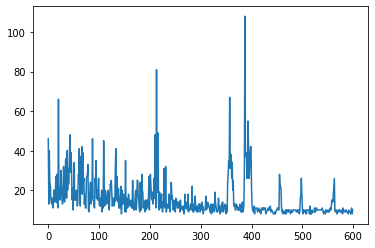

In [31]:
import matplotlib.pyplot as plt
plt.plot(reward_array)

In [29]:
reward_array[1200-1]

22